In [ ]:
dataset = "TransnetBW.csv"
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from torch.utils.data import TensorDataset, DataLoader
import time
import os
import pandas as pd
def pad(arr, length):
    arr = np.array(arr, dtype=np.float32)
    if len(arr) < length:
        arr = np.concatenate([arr, np.full(length - len(arr), np.nan)])
    return arr

device: cpu

Training quantile 0.05
Epoch 10, Loss: 0.0538
Epoch 20, Loss: 0.0481
Epoch 30, Loss: 0.0459
Epoch 40, Loss: 0.0445
Epoch 50, Loss: 0.0438

Training quantile 0.95
Epoch 10, Loss: 0.1004
Epoch 20, Loss: 0.0882
Epoch 30, Loss: 0.0817
Epoch 40, Loss: 0.0764
Epoch 50, Loss: 0.0693

Metrics:
PICP: 0.734
MPIW: 3953.423
Training time: 10.97 seconds
Plot saved as results/withoutaci/ann_quantile.png


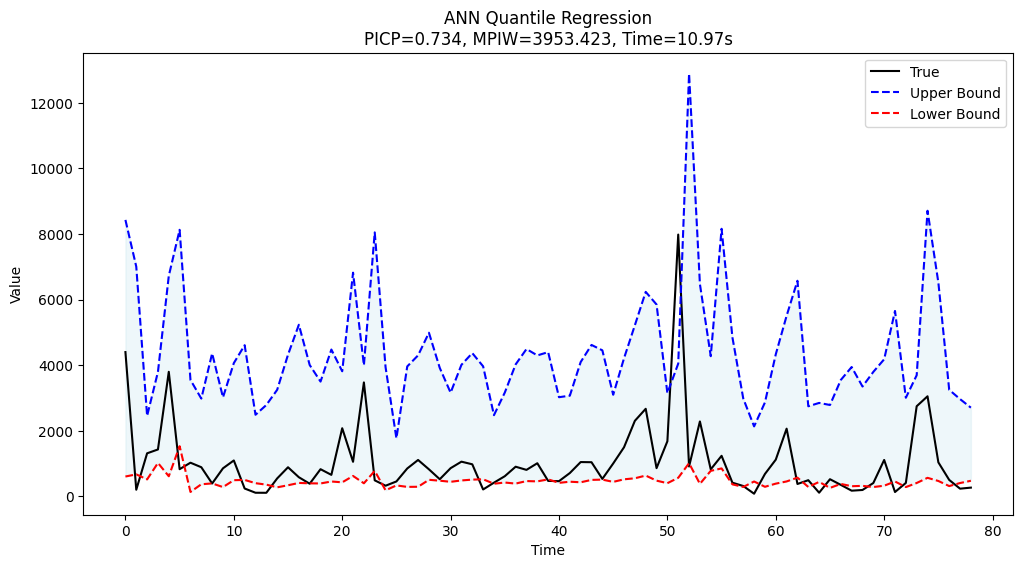

Results saved to results/withoutaci/ann_quantile_results.csv
Local metrics plot saved as results/withoutaci/local_metrics_ann_quantile.png


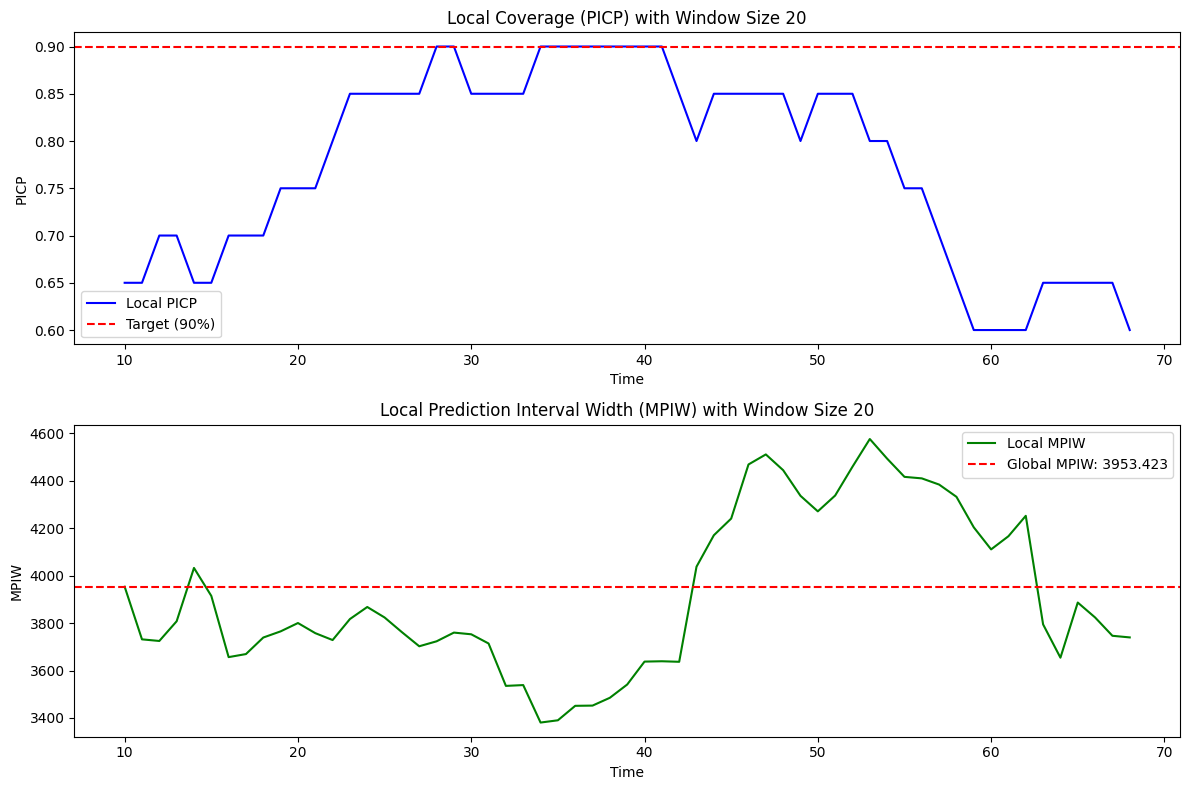

In [ ]:
from models import ANNQuantileReg 
from loss_functions import quantile_loss
SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
QUANTILES = [0.05, 0.95] 
os.makedirs("results/withoutaci", exist_ok=True)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)
split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


start_time = time.time()
models = []

for q in QUANTILES:
    model = ANNQuantileReg(input_dim=SEQ_LEN, hidden_dim=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    print(f"\nTraining quantile {q}")
    for epoch in range(EPOCHS):
        model.train()
        epoch_losses = []
        
        for X_batch, y_batch in train_loader:
            preds = model(X_batch)
            loss = quantile_loss(y_batch, preds, q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")
    
    models.append(model)


models[0].eval()  
models[1].eval()  

with torch.no_grad():
    y_l_preds = models[0](X_test_tensor).cpu().numpy().flatten()
    y_u_preds = models[1](X_test_tensor).cpu().numpy().flatten()

end_time = time.time()
time_taken = end_time - start_time


y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, 
                alpha=0.2, color='lightblue')
plt.legend()
title = f"ANN Quantile Regression,Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/withoutaci/ann_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()
max_len = max(
    len(y_u_preds_inv),
    len(y_l_preds_inv),
)
results_df = pd.DataFrame({
    "y_u_preds_inv":pad(y_u_preds_inv,max_len),
    "y_l_preds_inv":pad(y_l_preds_inv,max_len),
    "y_true_vals_inv":pad(y_test_inv,max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1),
})
csv_filename = "results/withoutaci/ann_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

device: cpu
Epoch 10, Loss: 0.1988
Epoch 20, Loss: 0.1726
Epoch 30, Loss: 0.1657
Epoch 40, Loss: 0.1666
Epoch 50, Loss: 0.1557

Metrics:
PICP: 0.861
MPIW: 3805.349
Training time: 1.69 seconds
Plot saved as results/withoutaci/ann_tube.png


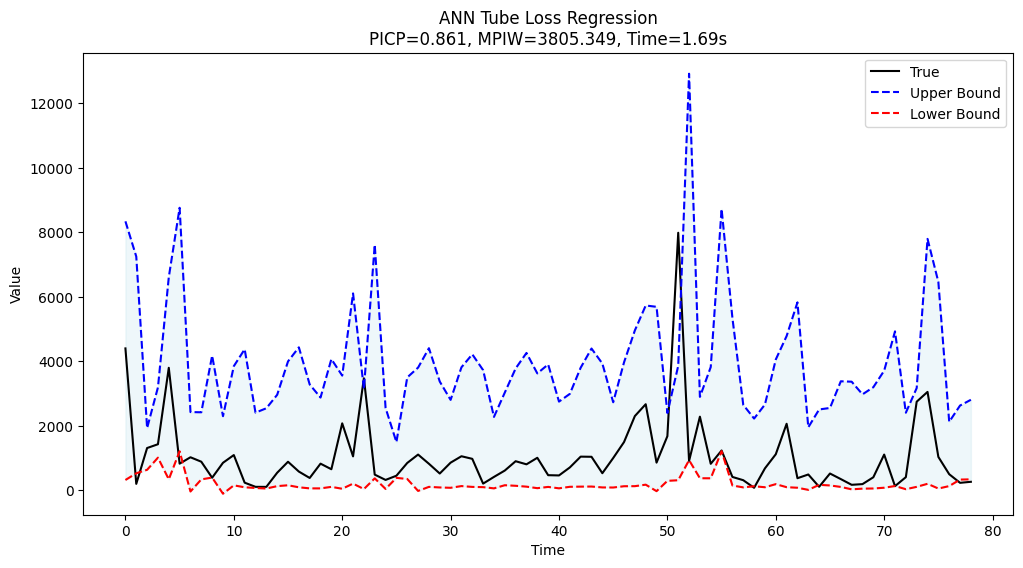

Results saved to results/withoutaci/ann_tube_results.csv
Local metrics plot saved as results/withoutaci/local_metrics_ann_tube.png


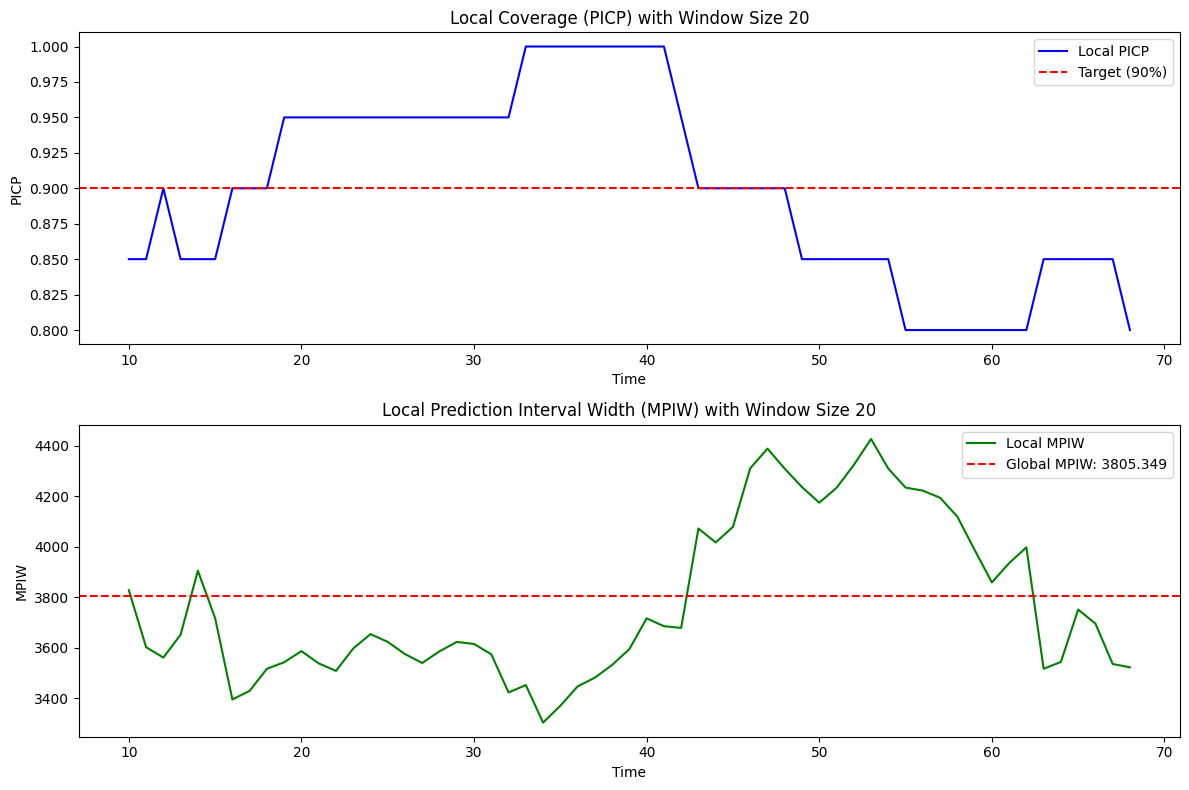

In [ ]:
from models import ANNTubeReg
from loss_functions import tube_loss
SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1  

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)
split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)


train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
model = ANNTubeReg(input_dim=SEQ_LEN, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    
    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = tube_loss(y_batch, preds, q=1-ALPHA, r=0.5, delta=0.0006)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")

model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    y_u_preds, y_l_preds = preds[:, 0], preds[:, 1]

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, 
                alpha=0.2, color='lightblue')
plt.legend()
title = f"ANN Tube Loss Regression,Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/withoutaci/ann_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
max_len= max(len(y_u_preds),len(y_l_preds_inv))
results_df = pd.DataFrame({
    "y_u_preds_inv":pad(y_u_preds_inv,max_len),
    "y_l_preds_inv":pad(y_l_preds_inv,max_len),
    "y_true_vals_inv":pad(y_test_inv,max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1),
})
csv_filename = "results/withoutaci/ann_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

device: cpu

Training quantile 0.05
Epoch 10, Loss: 0.0529
Epoch 20, Loss: 0.0531
Epoch 30, Loss: 0.0529
Epoch 40, Loss: 0.0524
Epoch 50, Loss: 0.0521

Training quantile 0.95
Epoch 10, Loss: 0.1160
Epoch 20, Loss: 0.1108
Epoch 30, Loss: 0.1039
Epoch 40, Loss: 0.0983
Epoch 50, Loss: 0.0952

Metrics:
PICP: 0.810
MPIW: 5735.188
Training time: 2.76 seconds
Plot saved as results/withoutaci/lstm_quantile.png


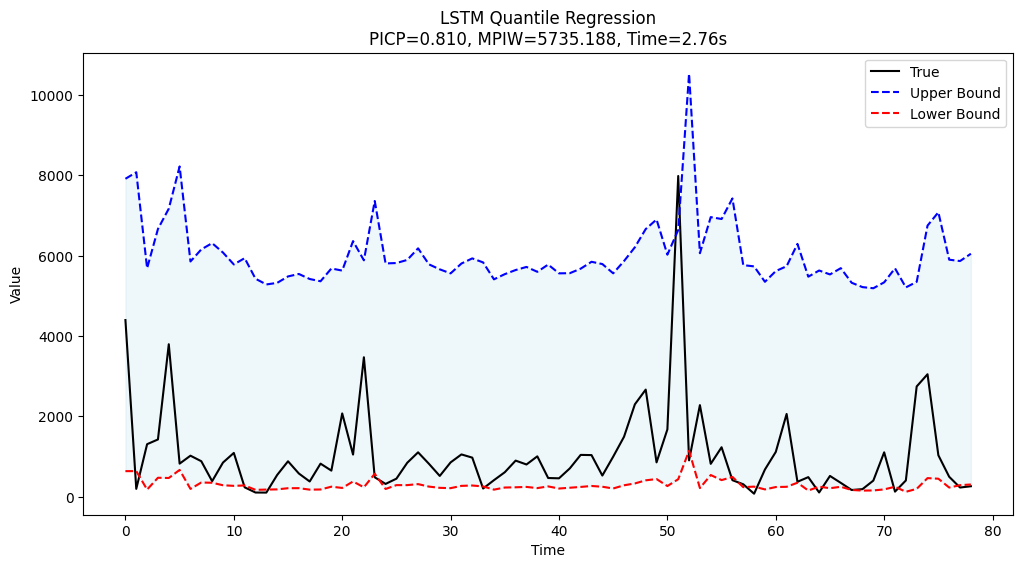

Results saved to results/withoutaci/lstm_quantile_results.csv
Local metrics plot saved as results/withoutaci/local_metrics_lstm_quantile.png


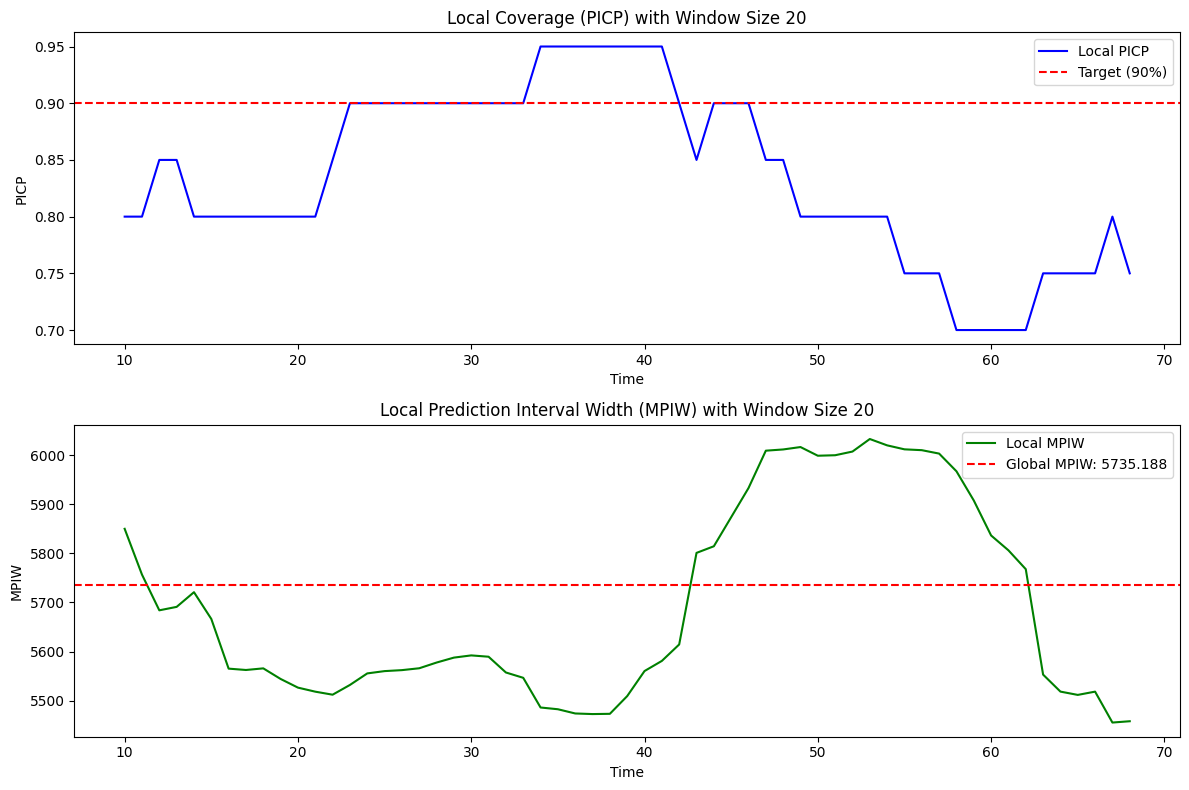

In [ ]:
from models import LSTMQuantileReg
from loss_functions import quantile_loss

SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]

start_time = time.time()
quantiles = [ALPHA/2.0, 1.0 - ALPHA/2.0]
models = []

for q in quantiles:
    model = LSTMQuantileReg().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    print(f"\nTraining quantile {q}")
    for epoch in range(EPOCHS):
        model.train()
        epoch_losses = []
        
        for X_batch, y_batch in train_loader:
            preds = model(X_batch)
            loss = quantile_loss(y_batch, preds, q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")
    
    models.append(model)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
models[0].eval()
models[1].eval()

with torch.no_grad():
    y_l_preds = models[0](X_test_tensor).cpu().numpy().flatten()
    y_u_preds = models[1](X_test_tensor).cpu().numpy().flatten()

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

inside = (y_test_inv >= y_l_preds_inv) & (y_test_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2, color='lightblue')
plt.legend()
title = f"LSTM Quantile Regression\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/withoutaci/lstm_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()


max_len = max(
    len(y_u_preds_inv),
    len(y_l_preds_inv),
)
results_df = pd.DataFrame({
    "y_u_preds_inv":pad(y_u_preds_inv,max_len),
    "y_l_preds_inv":pad(y_l_preds_inv,max_len),
    "y_true_vals_inv":pad(y_test_inv,max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1),
})
csv_filename = "results/withoutaci/lstm_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

device: cpu
Epoch 10, Loss: 0.2191
Epoch 20, Loss: 0.2141
Epoch 30, Loss: 0.1985
Epoch 40, Loss: 0.1933
Epoch 50, Loss: 0.1853

Metrics:
PICP: 0.924
MPIW: 3772.790
Training time: 1.66 seconds
Plot saved as results/withoutaci/lstm_tube.png


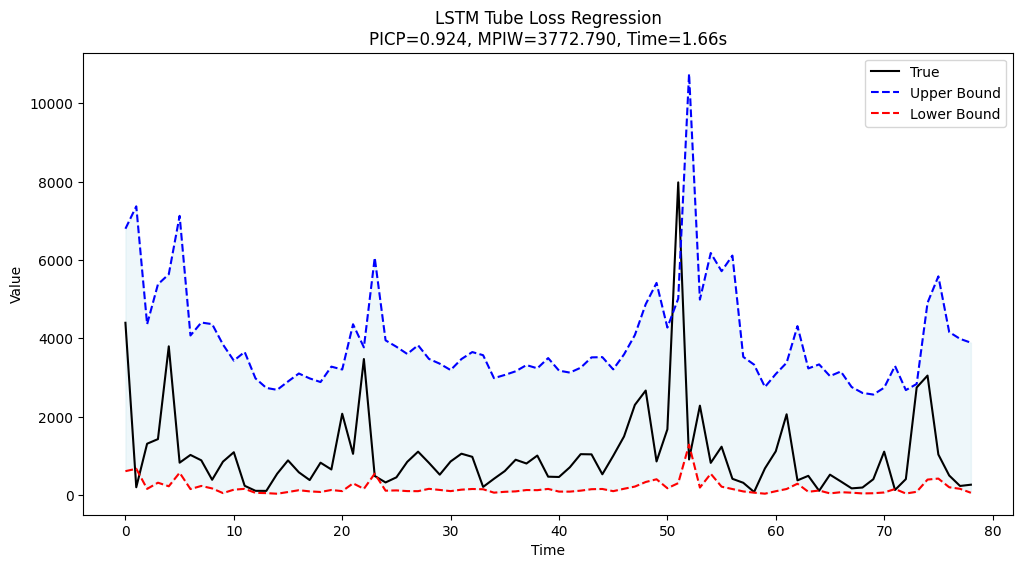

Results saved to results/withoutaci/lstm_tube_results.csv
Local metrics plot saved as results/withoutaci/local_metrics_lstm_tube.png


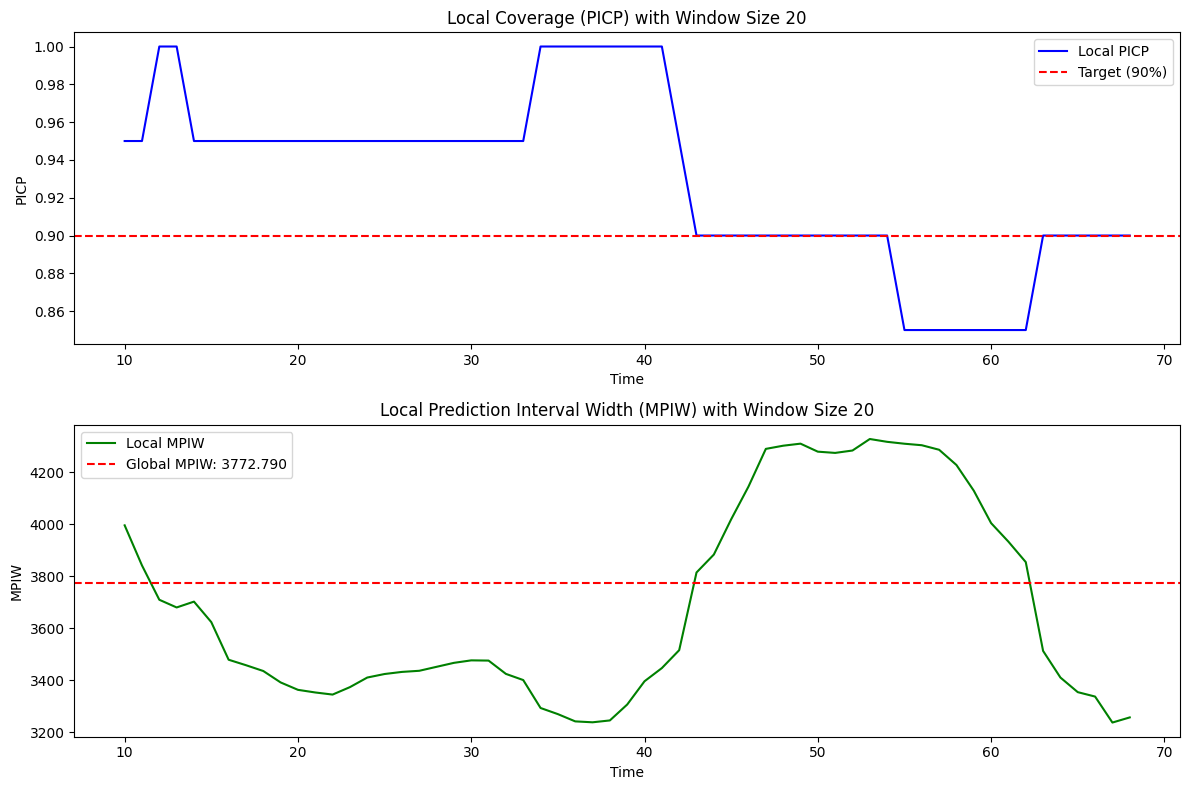

In [ ]:

from models import LSTMTubeReg
from loss_functions import tube_loss

SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]

model = LSTMTubeReg().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    
    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = tube_loss(y_batch, preds, q=1-ALPHA, r=0.5, delta=0.0006)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")

model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    y_u_preds, y_l_preds = preds[:, 0], preds[:, 1]

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

inside = (y_test_inv >= y_l_preds_inv) & (y_test_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2, color='lightblue')
plt.legend()
title = f"LSTM Tube Loss Regression\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/withoutaci/lstm_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()
max_len = max(
    len(y_u_preds_inv),
    len(y_l_preds_inv),
)
results_df = pd.DataFrame({
    "y_u_preds_inv":pad(y_u_preds_inv,max_len),
    "y_l_preds_inv":pad(y_l_preds_inv,max_len),
    "y_true_vals_inv":pad(y_test_inv,max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1)
})
csv_filename = "results/withoutaci/lstm_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

device: cpu

Training quantile 0.05
Epoch 10, Loss: 0.0563
Epoch 20, Loss: 0.0548

Training quantile 0.95
Epoch 10, Loss: 0.1025
Epoch 20, Loss: 0.0916

Metrics:
PICP: 0.962
MPIW: 5619.685
Training time: 5.20 seconds
Plot saved as results/withoutaci/tcn_quantile.png


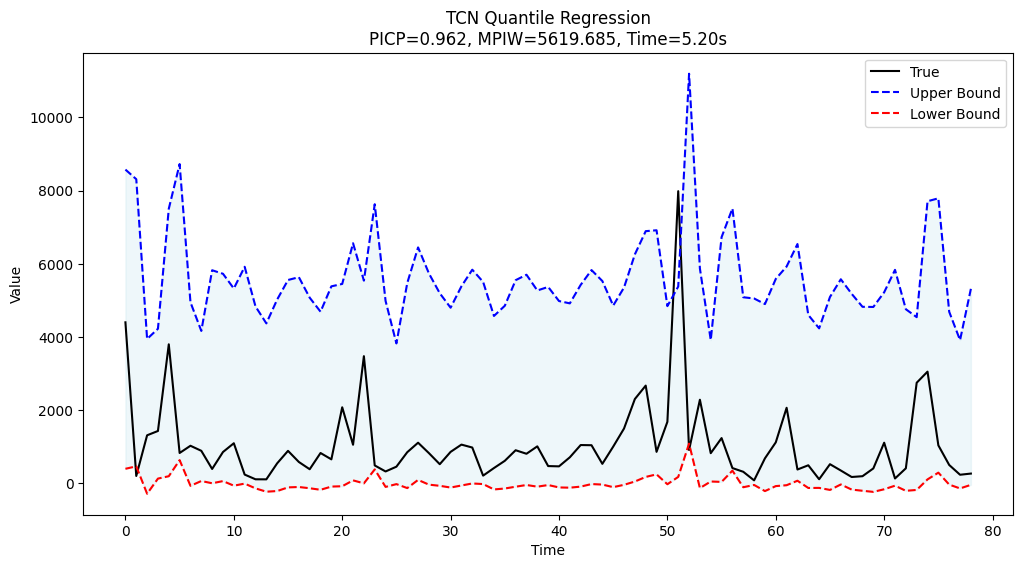

Results saved to results/withoutaci/tcn_quantile_results.csv
Local metrics plot saved as results/withoutaci/local_metrics_tcn_quantile.png


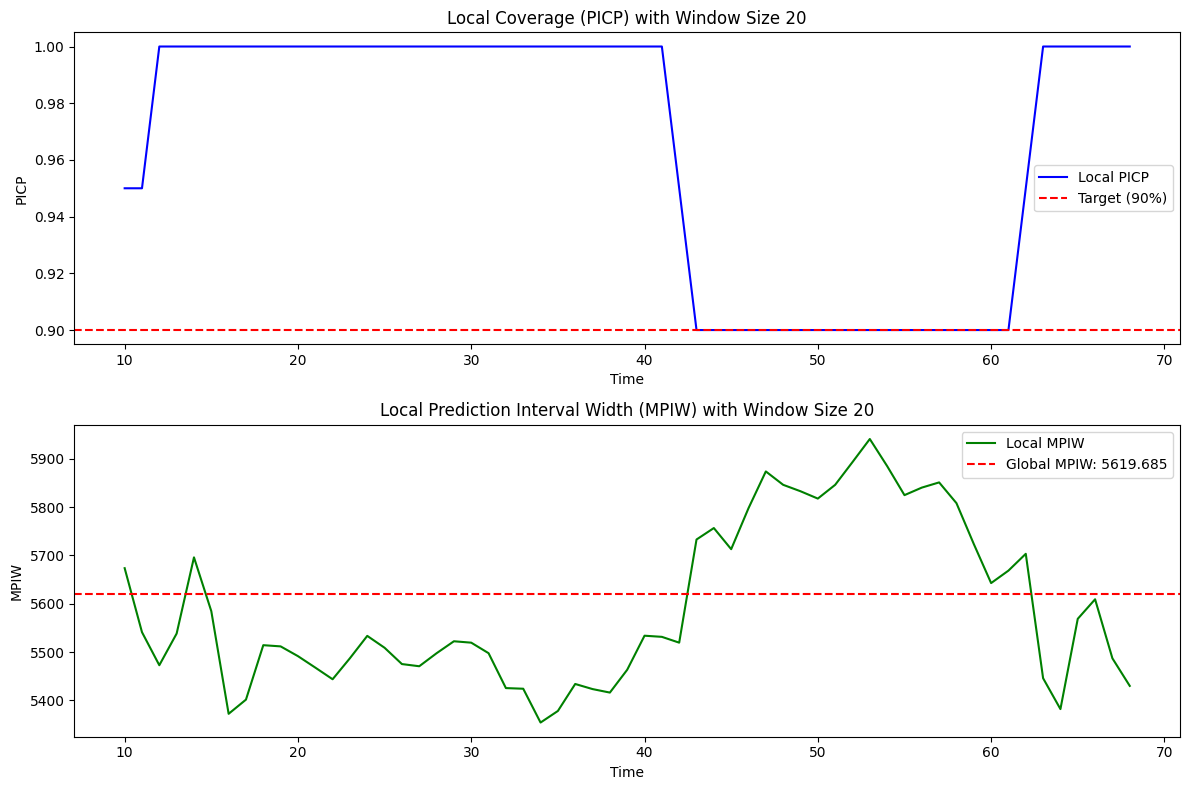

In [ ]:
from models import TCNQuantileReg
from loss_functions import quantile_loss
SEQ_LEN = 5
EPOCHS = 20
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]

quantiles = [ALPHA/2.0, 1.0 - ALPHA/2.0]
models = []
start_time = time.time()
for q in quantiles:
    model = TCNQuantileReg(input_dim=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    print(f"\nTraining quantile {q}")
    for epoch in range(EPOCHS):
        model.train()
        epoch_losses = []
        
        for X_batch, y_batch in train_loader:
            preds = model(X_batch)
            loss = quantile_loss(y_batch, preds, q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")
    
    models.append(model)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
models[0].eval()
models[1].eval()

with torch.no_grad():
    y_l_preds = models[0](X_test_tensor).cpu().numpy().flatten()
    y_u_preds = models[1](X_test_tensor).cpu().numpy().flatten()

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

inside = (y_test_inv >= y_l_preds_inv) & (y_test_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2, color='lightblue')
plt.legend()
title = f"TCN Quantile Regression\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/withoutaci/tcn_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()

max_len = max(
    len(y_u_preds_inv),
    len(y_l_preds_inv),
)
results_df = pd.DataFrame({
    "y_u_preds_inv":pad(y_u_preds_inv,max_len),
    "y_l_preds_inv":pad(y_l_preds_inv,max_len),
    "y_true_vals_inv":pad(y_test_inv,max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/withoutaci/tcn_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

device: cpu
Epoch 10, Loss: 0.1954
Epoch 20, Loss: 0.1780

Metrics:
PICP: 0.899
MPIW: 4219.265
Training time: 2.67 seconds
Plot saved as results/withoutaci/tcn_tube.png


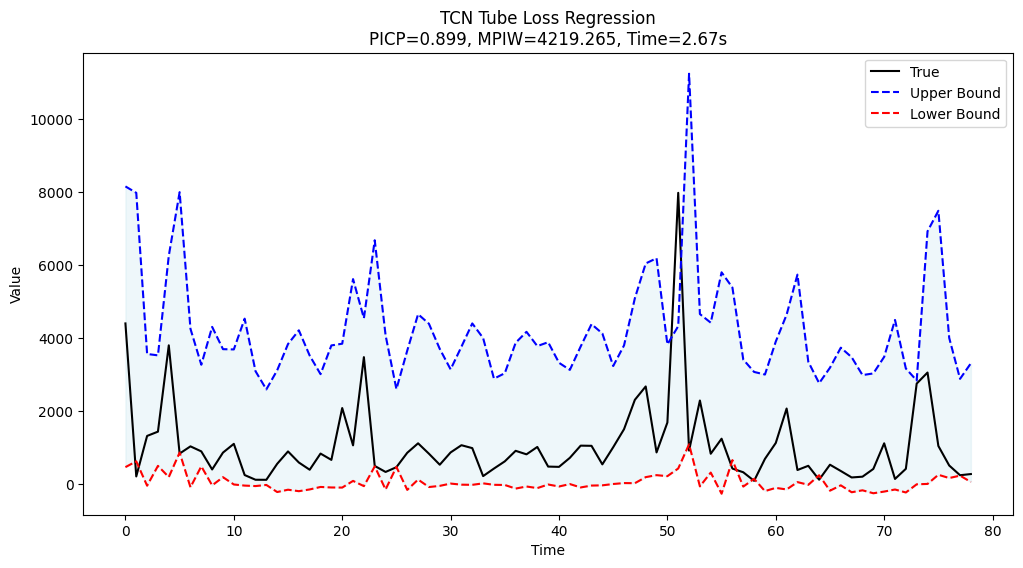

Results saved to results/withoutaci/tcn_tube_results.csv
Local metrics plot saved as results/withoutaci/local_metrics_tcn_tube.png


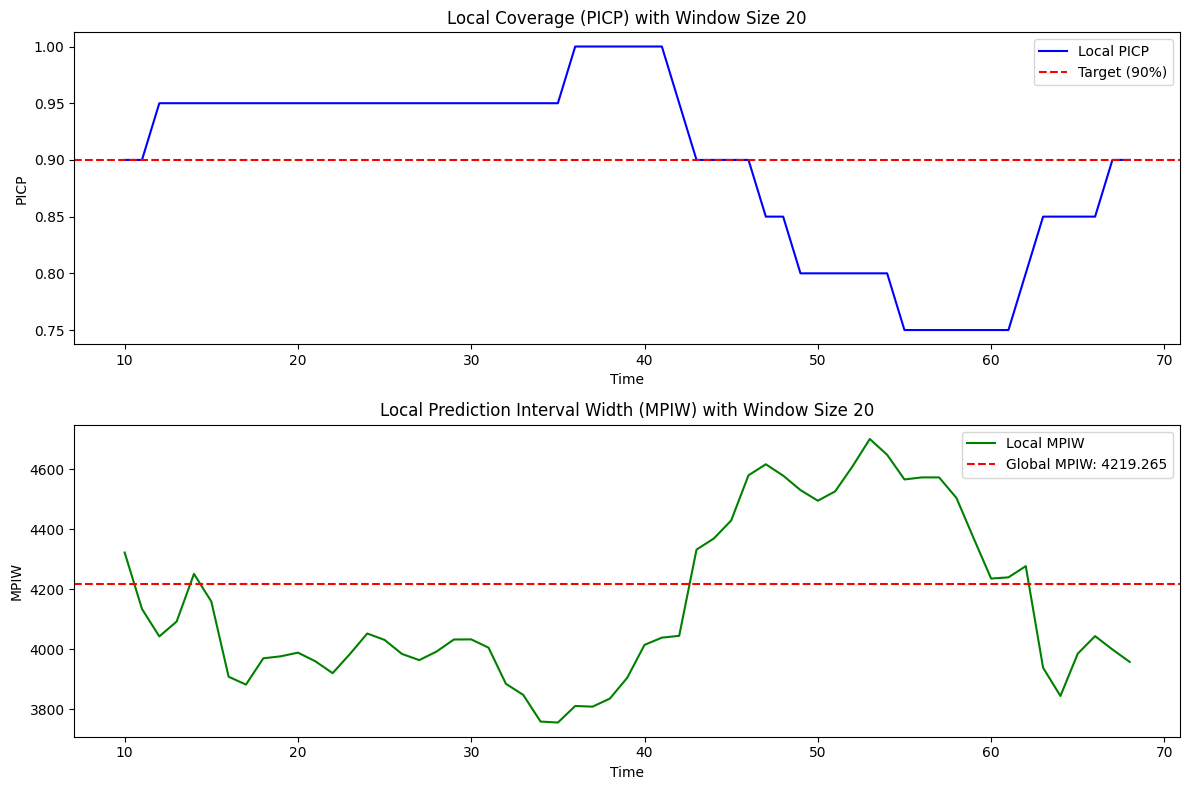

In [ ]:
from models import TCNTubeReg
from loss_functions import tube_loss
SEQ_LEN = 5
EPOCHS = 20
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_dataset, scaler, y, y_scaled = load_data_1("TransnetBW.csv", SEQ_LEN)
split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]

model = TCNTubeReg(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    
    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = tube_loss(y_batch, preds, q=1-ALPHA, r=0.5, delta=0.005)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")

model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    y_u_preds, y_l_preds = preds[:, 0], preds[:, 1]

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

inside = (y_test_inv >= y_l_preds_inv) & (y_test_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2, color='lightblue')
plt.legend()
title = f"TCN Tube Loss Regression\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/withoutaci/tcn_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()
max_len = max(
    len(y_u_preds_inv),
    len(y_l_preds_inv),
)
results_df = pd.DataFrame({
    "y_u_preds_inv":pad(y_u_preds_inv,max_len),
    "y_l_preds_inv":pad(y_l_preds_inv,max_len),
    "y_true_vals_inv":pad(y_test_inv,max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1),
})
csv_filename = "results/withoutaci/tcn_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

In [ ]:
from models import GRUTubeReg      
from loss_functions import tube_loss

def pad(arr, length):
    arr = np.array(arr, dtype=np.float32)
    if len(arr) < length:
        arr = np.concatenate([arr, np.full(length - len(arr), np.nan)])
    return arr

SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)
split_idx = int(0.8 * len(full_dataset.X))
X_train, y_train = full_dataset.X[:split_idx], full_dataset.y[:split_idx]
X_test, y_test = full_dataset.X[split_idx:], full_dataset.y[split_idx:]

model = GRUTubeReg().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    
    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = tube_loss(y_batch, preds, q=1-ALPHA, r=0.5, delta=0.0005)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")

model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    y_u_preds, y_l_preds = preds[:, 0], preds[:, 1]

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

inside = (y_test_inv >= y_l_preds_inv) & (y_test_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2, color='lightblue')
plt.legend()
title = f"GRU Tube Loss Regression\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")


os.makedirs("results/withoutaci", exist_ok=True)
filename = "results/withoutaci/gru_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()

max_len = max(len(y_u_preds_inv), len(y_l_preds_inv))
results_df = pd.DataFrame({
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_test_inv, max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1)
})

csv_filename = "results/withoutaci/gru_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

In [ ]:
from models import GRUQuantileReg     
from loss_functions import quantile_loss

def pad(arr, length):
    arr = np.array(arr, dtype=np.float32)
    if len(arr) < length:
        arr = np.concatenate([arr, np.full(length - len(arr), np.nan)])
    return arr


SEQ_LEN = 5
EPOCHS = 20
LR = 0.001
SEED = 42
BATCH_SIZE = 32
ALPHA = 0.1


torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)
split_idx = int(0.8 * len(full_dataset.X))
X_train = full_dataset.X[:split_idx]
y_train = full_dataset.y[:split_idx]
X_test = full_dataset.X[split_idx:]
y_test = full_dataset.y[split_idx:]


quantiles = [ALPHA/2.0, 1.0 - ALPHA/2.0]
models = []

start_time = time.time()
for q in quantiles:
    model = GRUQuantileReg(input_dim=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    print(f"\nTraining quantile {q}")
    for epoch in range(EPOCHS):
        model.train()
        epoch_losses = []
        
        for X_batch, y_batch in train_loader:
            preds = model(X_batch)
            loss = quantile_loss(y_batch, preds, q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}")
    
    models.append(model)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
models[0].eval()
models[1].eval()

with torch.no_grad():
    y_l_preds = models[0](X_test_tensor).cpu().numpy().flatten()
    y_u_preds = models[1](X_test_tensor).cpu().numpy().flatten()

end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()


inside = (y_test_inv >= y_l_preds_inv) & (y_test_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="True", color='black')
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--", color='blue')
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--", color='red')
plt.fill_between(range(len(y_test_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2, color='lightblue')
plt.legend()
title = f"GRU Quantile Regression\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")


os.makedirs("results/withoutaci", exist_ok=True)
filename = "results/withoutaci/gru_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"\nMetrics:")
print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")
print(f"Training time: {time_taken:.2f} seconds")
print(f"Plot saved as {filename}")
plt.show()


max_len = max(len(y_u_preds_inv), len(y_l_preds_inv))
results_df = pd.DataFrame({
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_test_inv, max_len),
    "time": [time_taken] + [np.nan] * (max_len - 1),
})

csv_filename = "results/withoutaci/gru_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")
